In [ ]:
import logging
from typing import Callable, Literal, Optional, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize

from bwlogger import StyleAdapter
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional, Union, Any

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from aamalha.utils.performance import Performance
from bwbbgdl import GoGet
from bwlogger import StyleAdapter, basic_setup
from bwutils import TODAY, Date

from portfolio.construction import calculate_weights

from utils import (
    get_available_trackers,
    load_trackers,
    correlation_to_distance,
    cap_long_only_weights,
    
)
from plot import plot_results, scatter_plot, stacked_area_plot, line_plot, lines_plot

In [ ]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados")
INVERSE_QUOTED = (
    "JPY",
    "HKD",
    "PHP",
    "CHF",
    "CZK",
    "CAD",
    "CLP",
    "DKK",
    "NOK",
    "SEK",
    "RUB",
    "BRL",
    "MXN",
    "HUF",
    "PLN",
    "TRY",
    "ILS",
    "INR",
    "TWD",
    "KRW",
    "IDR",
    "CNH",
    "CNY",
    "SGD",
    "ZAR",
    "THB",
    "COP",
    "MYR",
    "HKD",
)

## Load Data

### Bloomberg Data

In [ ]:
path = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\Projeto Asset Allocation.xlsx"
df_base = pd.read_excel(path, index_col=0, skiprows=1, sheet_name="base_values")
df_base

### Auxiliar Table

In [ ]:
df_base_aux = pd.read_excel(path, index_col=0, usecols="A:F", sheet_name="aux")
df_base_aux

### Trackers

In [ ]:
ONSHORE_BENHCMARK = "BZACCETP Index"
OFFSHORE_BENHCMARK = "G0O1 Index"

list_trackers = []
for ticker in df_base_aux[df_base_aux["include"]].index:
    alias = df_base_aux.loc[ticker, "alias"]
    curncy = df_base_aux.loc[ticker, "currency"]
    excess_index = df_base_aux.loc[ticker, "excess_index"]
    s_total_return = df_base[ticker].copy().dropna()

    if curncy == "BRL":
        s_benchmark_return = df_base[ONSHORE_BENHCMARK]
    else: 
        s_benchmark_return = df_base[OFFSHORE_BENHCMARK]
        if curncy != "USD":
            s_total_return_local_ccy = s_total_return
            curncy = "EUR"
            ccy = df_base[f"USD{curncy} Curncy"].copy()
            if curncy in INVERSE_QUOTED:
                ccy = 1 / ccy
            s_total_return_usd = (s_total_return_local_ccy.diff(1) * ccy).dropna()
            s_total_return_usd = s_total_return_usd.reindex(s_total_return_local_ccy.index)
            s_total_return_usd.iloc[0] = (
                s_total_return_local_ccy.iloc[0] * ccy[s_total_return_usd.index[0]]
            )
            s_total_return_usd = s_total_return_usd.cumsum()
            s_total_return = s_total_return_usd.copy()

    if excess_index:
        s_excess_return = s_benchmark_return*0 + 1
    s_excess_return = (s_total_return / s_benchmark_return).dropna()
    s_excess_return.name = alias
    s_excess_return = s_excess_return / s_excess_return.iloc[0] * 100
    list_trackers.append(s_excess_return)

df_trackers = pd.concat(list_trackers, axis=1)

df_trackers.to_excel(
    OUTPUT_FOLDER.joinpath("trackers_excess_returns.xlsx")
)
lines_plot(
    df_trackers.apply(lambda col: col / col.dropna().iloc[0] - 1),
    plot_title="Performance Trackers",
    output_path=OUTPUT_FOLDER.joinpath("trakcers_performance.svg"),
)

## Analysis

### Performance Trackers

In [ ]:
perf_trackers = Performance(df_trackers)
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.to_excel(OUTPUT_FOLDER.joinpath("performance_trackers.xlsx"))

In [ ]:
df_performance

### Correlation

In [ ]:
df_corr = np.log(df_trackers).diff(1).corr().copy()
df_corr.to_excel(OUTPUT_FOLDER.joinpath("full_sample_correlation.xlsx"))
df_corr

### Dendogram

In [ ]:
linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="right",
    labels=df_corr.columns,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Assets")
plt.xlabel("Distance")
plt.savefig(OUTPUT_FOLDER.joinpath("dendrogram.svg"), tight_layout=True)
plt.show()

## Portfolio Construction

In [ ]:
def backtest2(
    tracker_df: pd.DataFrame,
    vol_target: float = 0.2,
    method_weights: Literal["hrp", "minvar", "ivp", "erc"] = "ivp",
    cap: Optional[float] = None, 
) -> tuple[pd.DataFrame, pd.DataFrame]:
    name = f"{method_weights}" + (f"_{cap:.0%}" if cap else "")
    print(name)

    STARTING_DATA_POINTS = 252 * 3
    STARTING_DATA_POINTS = 1305
    return_days = 21
    min_data_points = 252

    backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days :])
    backtest.iloc[0] = 100.0

    starting_trackers = get_available_trackers(
        tracker_df.iloc[: STARTING_DATA_POINTS + return_days],
        STARTING_DATA_POINTS,
    )
    cov = (
        np.log(tracker_df)[starting_trackers].diff(return_days).cov()
        * 252
        / return_days
    )
    # print(starting_trackers)
    w = calculate_weights(
        np.log(tracker_df[starting_trackers]).diff(1),
        method=method_weights,
        long_only=True,
    )
    w = cap_long_only_weights(w, cap=cap)
    # print(w.to_string())
    adj_factor = vol_target / np.sqrt(w @ cov @ w)
    w = adj_factor * w
    q = backtest.iloc[0] * w / tracker_df.iloc[0]
    dict_positions = {}
    dict_positions[backtest.index[0]] = q.to_dict()

    for t, tm1 in zip(backtest.index[1:], backtest.index[:-1]):
        pnl = ((tracker_df.loc[t] - tracker_df.loc[tm1]) * q).sum()
        dict_positions[t] = ((tracker_df.loc[t] / tracker_df.loc[tm1]) * q).to_dict()
        backtest[t] = backtest[tm1] + pnl
        if t.month != tm1.month:
            # print("Rebalance %s" % t.strftime("%m/%d/%Y"))
            available_trackers = get_available_trackers(
                tracker_df.loc[:t], min_data_points + return_days
            )
            # print("Available Trackers %s" % available_trackers)
            cov = (
                np.log(tracker_df.loc[:t][available_trackers]).diff(return_days).cov()
                * 252
                / return_days
            )
            w = calculate_weights(
                np.log(tracker_df.loc[:t][available_trackers]).diff(1),
                method=method_weights,
                long_only=True,
            )
            w = cap_long_only_weights(w, cap=cap)
            # print(w.to_string())
            adj_factor = vol_target / np.sqrt(w @ cov @ w)
            w = adj_factor * w
            q = backtest[tm1] * w / tracker_df.loc[tm1]

    df_backtest = pd.concat(
        [tracker_df, backtest.to_frame(name)],
        axis=1,
        join="outer",
        sort=True,
    )
    df_backtest.name = method_weights
    df_positions = pd.DataFrame(dict_positions).T
    df_positions.name = name
    return df_backtest.copy(), df_positions.copy()


list_backtest = []
list_positions = []
methods_wegiths = ["hrp", "ivp", "erc"]
for method_weights in methods_wegiths:
    for cap in [n/10 for n in range(7, 1, -1)]:
        try:
            df_backtest, df_positions = backtest2(
                df_trackers, method_weights=method_weights, cap=cap
            )
            list_backtest.append(df_backtest.iloc[:, -1].copy())
            list_positions.append(df_positions.copy())
        except:
            print("Error: %s" % method_weights)
            pass

df_backtest = pd.concat(
    [df_trackers, *list_backtest],
    axis=1,
)

df_backtest.plot()

In [ ]:
perf_trackers = Performance(df_backtest.loc[df_backtest["hrp_20%"].dropna().index[0] :])
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.sort_values("Sharpe", ascending=False).to_excel(
    OUTPUT_FOLDER.joinpath("performance_table_backtest.xlsx")
)
df_performance.sort_values("Sharpe", ascending=False)

In [48]:
df_positions = backtest2(df_trackers, method_weights="ivp", cap=0.2)[1]
df_positions

ivp_20%


C:\Users\pcampos\AppData\Local\Temp\ipykernel_29204\1990783822.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days :])


,Ações Brasil,CSI 300 TR Index,Commodities,EURO STOXX 50 TR Index,FTSE 100 TR Index,HIS TR Index,HYG TR Index,Inflação (<5),Inflação (>5),NIFTY 50 TR Index,Nikkei 225 TR Index,Pre-fixados,S&P 500,S&P/TSX Composite TR Index,Treasury 20+ Y TR Index
2005-02-01,0.253821,NaN,0.253821,NaN,NaN,NaN,NaN,NaN,NaN,0.253821,NaN,NaN,0.253821,0.253821,NaN
2005-02-02,0.258441,NaN,0.252199,NaN,NaN,NaN,NaN,NaN,NaN,0.252969,NaN,NaN,0.254637,0.254649,NaN
2005-02-03,0.256418,NaN,0.251936,NaN,NaN,NaN,NaN,NaN,NaN,0.256778,NaN,NaN,0.253160,0.253783,NaN
2005-02-04,0.262405,NaN,0.253259,NaN,NaN,NaN,NaN,NaN,NaN,0.253634,NaN,NaN,0.256604,0.255096,NaN
2005-02-07,0.253821,NaN,0.252386,NaN,NaN,NaN,NaN,NaN,NaN,0.251283,NaN,NaN,0.253513,0.254111,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,0.660514,0.089978,0.769546,0.561430,0.371528,0.218856,0.977772,2.574704,1.248569,0.043110,0.236625,2.435737,0.158542,0.272616,0.649536
2024-06-21,0.664404,0.090470,0.761435,0.552462,0.366396,0.215666,0.979290,2.573216,1.253651,0.042856,0.235935,2.438160,0.158661,0.271297,0.653722
2024-06-24,0.666545,0.090169,0.775908,0.560106,0.373480,0.220254,0.977476,2.572106,1.248071,0.043070,0.237536,2.436901,0.158479,0.275870,0.656591
2024-06-25,0.657859,0.090141,0.760737,0.557192,0.367755,0.220977,0.979707,2.571805,1.242366,0.043361,0.238499,2.427671,0.159574,0.270891,0.655025


In [58]:
df_backtest = pd.concat(
    [df_backtest, df_positions],
    axis=1,
)

In [60]:
df_backtest.to_excel(OUTPUT_FOLDER.joinpath("backtest_cap_weights.xlsx"))

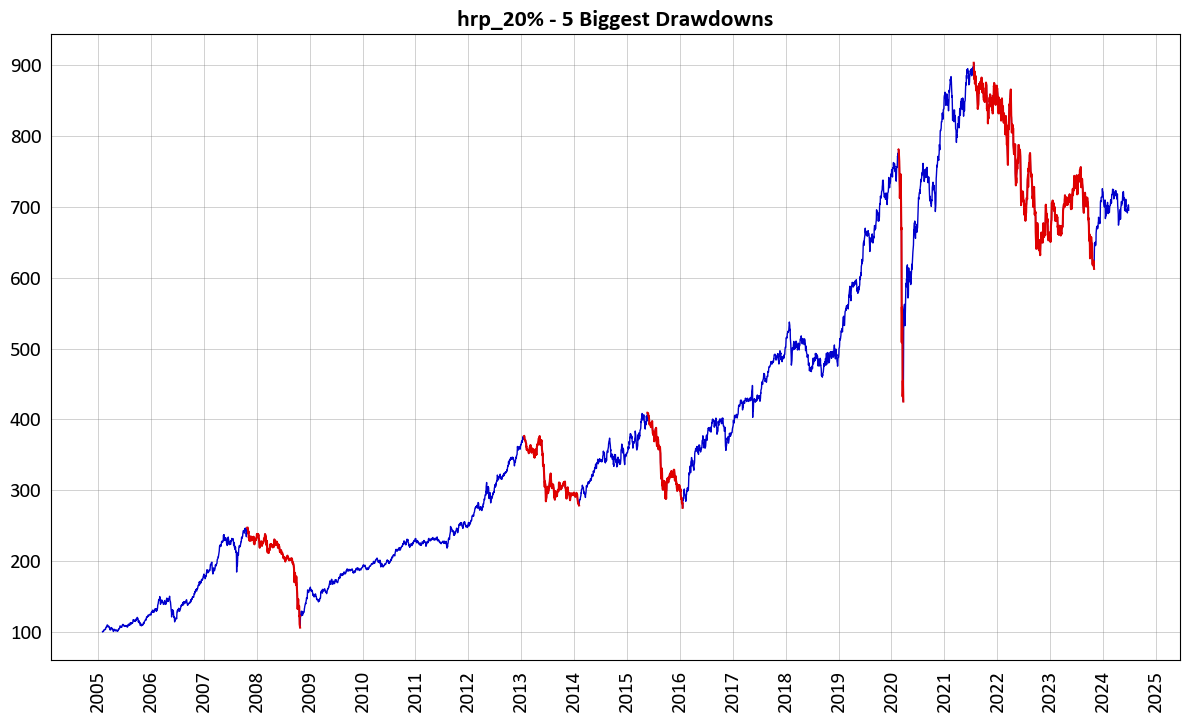

In [33]:
perf_trackers.plot_drawdowns("hrp_20%", show_chart=True)

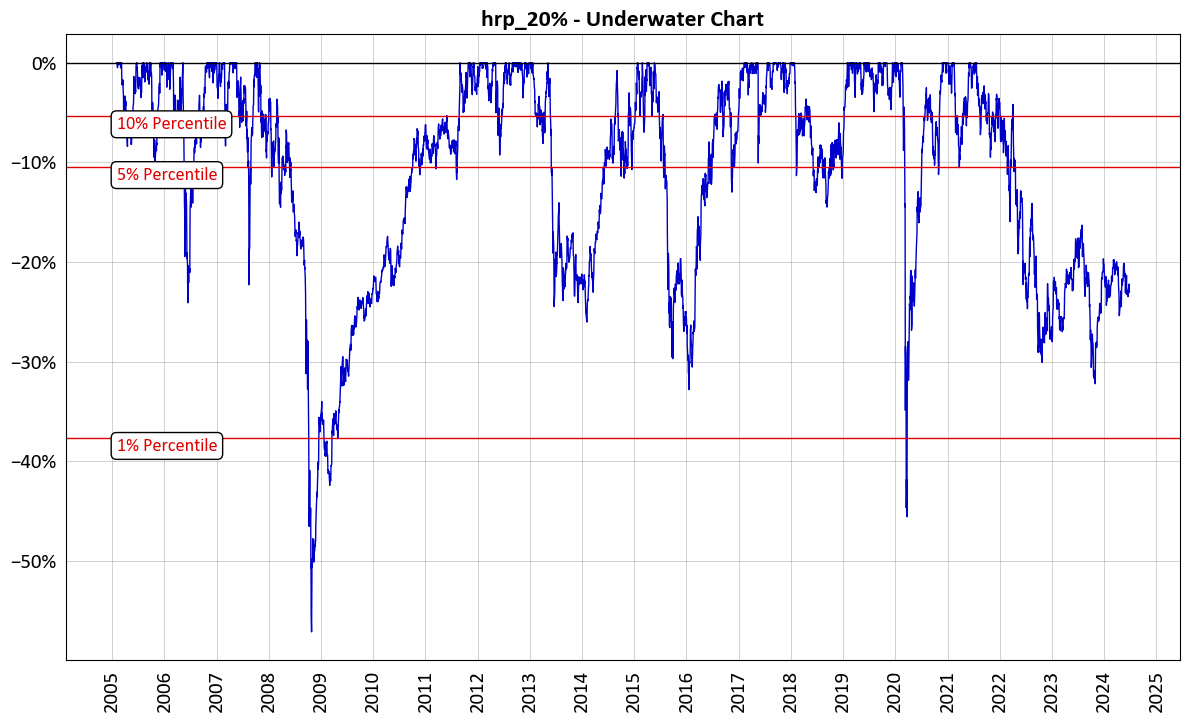

In [34]:
perf_trackers.plot_underwater("hrp_20%", show_chart=True)

# Plots

### Volatility

In [36]:
def load_series(column):
    return pd.read_excel(
        r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados\backtest_cap_weights.xlsx",
        index_col=0,
        usecols=f"A, {column}",
    ).iloc[:, 0].dropna()
s_backtest = load_series("V")
s_ibov = load_series("F")
s_sp500 = load_series("G")

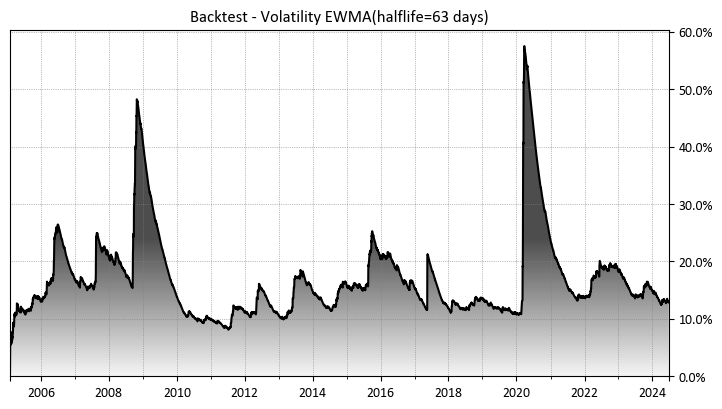

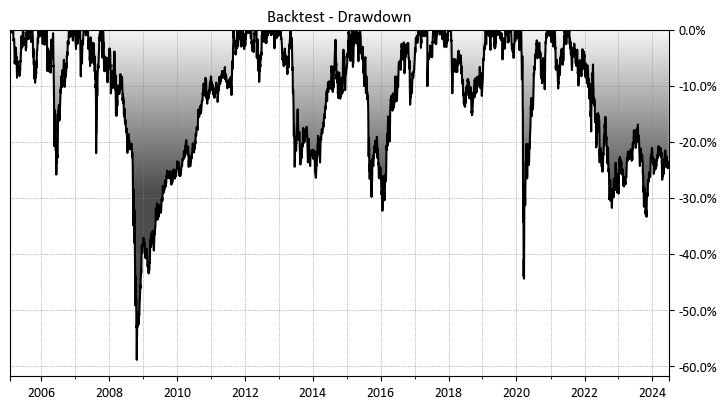

In [37]:
s_vol = (np.log(s_backtest).diff(1).ewm(halflife=63).std() * (252**0.5)).copy().dropna()
line_plot(
    s_vol,
    y_min=0,
    plot_title="Backtest - Volatility EWMA(halflife=63 days)",
    output_path=OUTPUT_FOLDER.joinpath("volatility.svg"),
)
s_drawdown = s_backtest / s_backtest.expanding().max() - 1
line_plot(
    s_drawdown,
    y_max=0,
    plot_title="Backtest - Drawdown",
    inverted=True,
    output_path=OUTPUT_FOLDER.joinpath("drawdown.svg"),
)

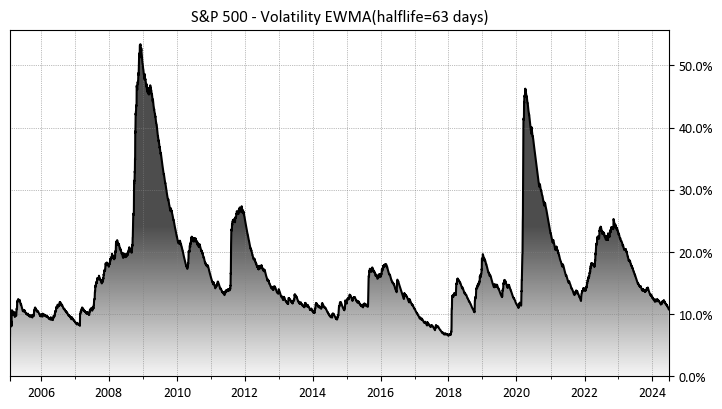

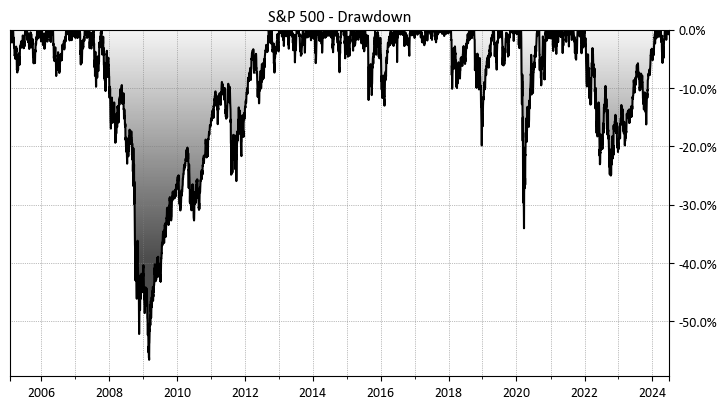

In [38]:
s_sp500 = s_sp500[s_backtest.index.min() :]
s_vol_sp500 = (
    (np.log(s_sp500).diff(1).ewm(halflife=63).std() * (252**0.5)).copy().dropna()
)
line_plot(
    s_vol_sp500,
    y_min=0,
    plot_title="S&P 500 - Volatility EWMA(halflife=63 days)",
    output_path=OUTPUT_FOLDER.joinpath("volatility_sp500.svg"),
)
s_drawdown_sp500 = s_sp500 / s_sp500.expanding().max() - 1
line_plot(
    s_drawdown_sp500,
    y_max=0,
    plot_title="S&P 500 - Drawdown",
    inverted=True,
    output_path=OUTPUT_FOLDER.joinpath("drawdown_sp500.svg"),
)

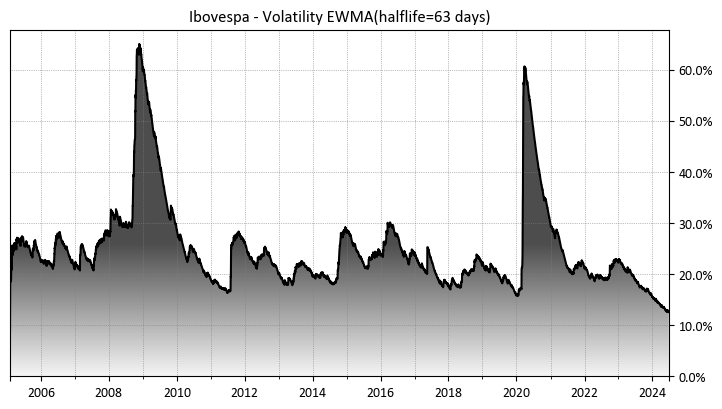

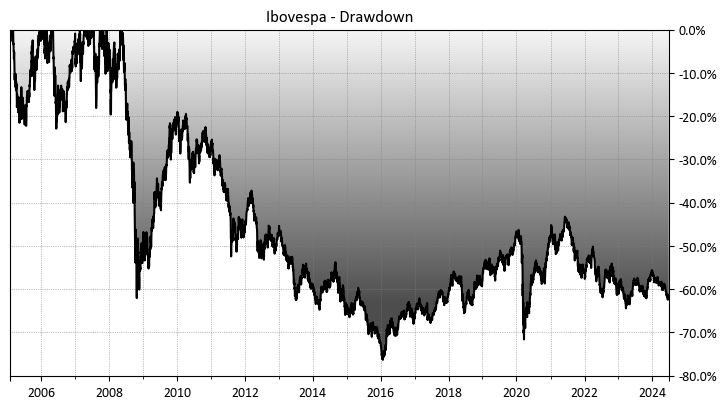

In [39]:
s_ibov = s_ibov[s_backtest.index.min():]
s_vol_ibov = (np.log(s_ibov).diff(1).ewm(halflife=63).std() * (252**0.5)).copy().dropna()
line_plot(
    s_vol_ibov,
    y_min=0,
    plot_title="Ibovespa - Volatility EWMA(halflife=63 days)",
    output_path=OUTPUT_FOLDER.joinpath("volatility_ibov.svg"),
)
s_drawdown_ibov = s_ibov / s_ibov.expanding().max() - 1
line_plot(
    s_drawdown_ibov,
    y_max=0,
    plot_title="Ibovespa - Drawdown",
    inverted=True,
    output_path=OUTPUT_FOLDER.joinpath("drawdown_ibov.svg"),
)

### Scatter Plot (vs IBOV)

In [43]:
# scatter_plot(
#     x_values=np.log(s_ibov).diff(21).dropna(),
#     y_values=np.log(s_backtest).diff(21).dropna(),
#     yaxis_title="Portfolio Returns",
#     xaxis_title="IBOV Returns",
#     plot_title="Scatter Plot of Portfolio Returns vs. IBOV Returns",
#     fit_type="linear",
#     output_path=OUTPUT_FOLDER.joinpath("scatter_plot_portvolio_vs_ibov.svg"),
# )

In [44]:
df_weights = pd.concat(
    [
        calculate_weights(np.log(df_trackers).diff(5), method, long_only=True)
        for method in ["hrp", "minvar", "ivp", "erc"]
    ],
    axis=1,
)

C:\Users\pcampos\.vscode\FinanceHub\portfolio\construction.py:55: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, method, metric)
C:\Users\pcampos\.vscode\FinanceHub\portfolio\construction.py:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_ix = sort_ix.append(df0)  # item 2
C:\Users\pcampos\.vscode\FinanceHub\portfolio\construction.py:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_ix = sort_ix.append(df0)  # item 2
C:\Users\pcampos\.vscode\FinanceHub\portfolio\construction.py:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sort_ix = sort_ix.append(df0)  # item 2
C:\Users\pcampos\.vscode\F

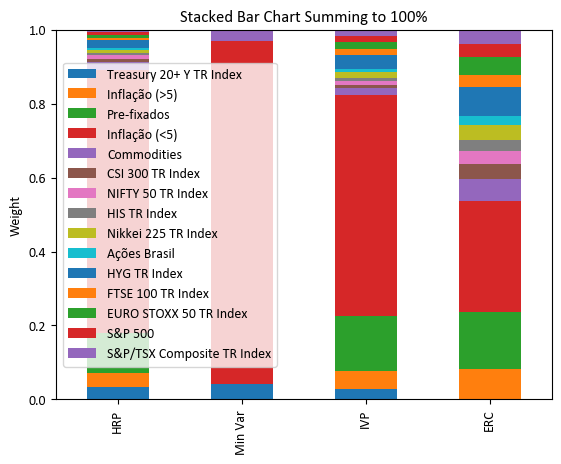

In [45]:

df_weights.T.plot(kind="bar", stacked=True)

plt.ylabel("Weight")
plt.title("Stacked Bar Chart Summing to 100%")
plt.show()

### Chart Allocation History

C:\Users\pcampos\AppData\Local\Temp\ipykernel_29204\3258415783.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_weights.columns = df_weights.columns.str.replace(".1", "")


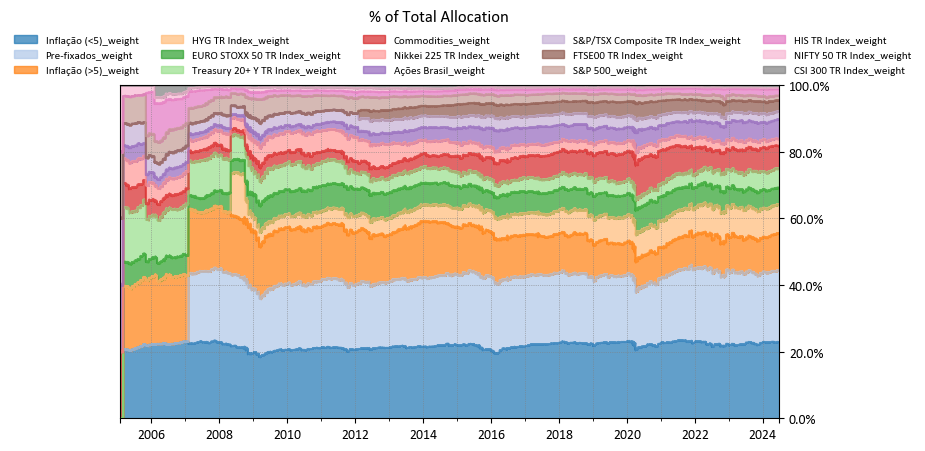

In [62]:
df_weights = pd.read_excel(
    r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados\backtest_cap_weights.xlsx",
    index_col=0,
    usecols="A,AI:AW",
)
df_weights.columns = df_weights.columns.str.replace(".1", "")
df_weights = df_weights.divide(df_weights.sum(axis=1), axis=0)
df = df_weights.copy()
df = df[df.mean().sort_values(ascending=False).index]

stacked_area_plot(
    df_weights,
    output_path=OUTPUT_FOLDER.joinpath("allocation_history.svg"),
)